In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import glob
from time import time
import os
from skimage.io import imread
import copy
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as Data
from torchvision import transforms
from torchvision.models import vgg19
from torchsummary import summary # 查看深度学习网络的深度

## 图像预处理

### 数据读取

In [16]:
## 定义计算设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
## 定义一个读取图像的函数
def read_image(root = "VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Segmentation/train.txt"):
    """读取指定路径下的所指定的图像文件"""
    image = np.loadtxt(root,dtype=str)
    n = len(image)
    data, label = [None]*n , [None]*n
    for i, fname in enumerate(image):
        data[i] = imread("VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/%s.jpg" %(fname))
        label[i] = imread("VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/SegmentationClass/%s.png" %(fname))
    return data,label

In [18]:
## 读取训练数据
traindata,trainlabel = read_image(root = "VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Segmentation/train.txt")
## 读取验证数据集
valdata,vallabel = read_image(root = "VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Segmentation/val.txt")
len(traindata),len(valdata)

(225, 197)

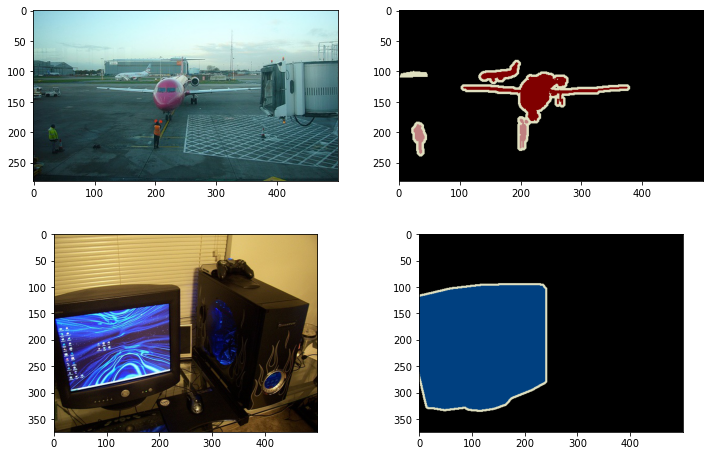

In [19]:
## 查看训练集和验证集的一些图像
plt.figure(figsize=(12,8)) #figsize:指定figure的宽和高，单位为英寸
plt.subplot(2,2,1) #subplot可以规划figure划分为n个子图，但每条subplot命令只会创建一个子图 
plt.imshow(traindata[0])
plt.subplot(2,2,2)
plt.imshow(trainlabel[0])
plt.subplot(2,2,3)
plt.imshow(traindata[10])
plt.subplot(2,2,4)
plt.imshow(trainlabel[10])
plt.show()

### 处理图像的类别标签

In [20]:
## 列出每个物体对应背景的RGB值
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']
# 每个类的RGB值
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

len(classes), len(colormap)

(21, 21)

In [7]:
## 给定一个标号图片，将像素值对应的物体找出来
def image2label(image,colormap):
    ## 将标签转化为没个像素值为1类数据
    cm2lbl = np.zeros(256**3)
    for i,cm in enumerate(colormap):
        cm2lbl[(cm[0]*256+cm[1]*256+cm[2])] = i
    ## 对一张图像准换
    image = np.array(image, dtype="int64")
    ix = (image[:,:,0]*256+image[:,:,1]*256+image[:,:,2])
    image2 = cm2lbl[ix]
    return image2

def center_crop(data, label, height, width):
    """data, label都是PIL.Image读取的图像"""
    ##使用中心裁剪（因为图像大小是一样的）
    data = transforms.CenterCrop((height, width))(data)
    label = transforms.CenterCrop((height, width))(label)
    return data, label

## 随机裁剪图像数据
def rand_crop(data,label,high,width):
    im_width,im_high = data.size
    ## 生成图像随机点的位置
    left = np.random.randint(0,im_width - width)
    top = np.random.randint(0,im_high - high)
    right = left+width
    bottom = top+high
    data = data.crop((left, top, right, bottom)) 
    label = label.crop((left, top, right, bottom)) 
    return data,label

## 单个图像的转换操作
def img_transforms(data, label, high,width,colormap):
    data, label = rand_crop(data, label, high,width)
    data_tfs = transforms.Compose([
        #transforms.resize(480,480),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
    data = data_tfs(data)
    label = torch.from_numpy(image2label(label,colormap))
    return data, label

## 定义一列出需要读取的数据路径的函数
def read_image_path(root = "VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Segmentation/train.txt"):
    """保存指定路径下的所有需要读取的图像文件路径"""
    image = np.loadtxt(root,dtype=str)
    n = len(image)
    data, label = [None]*n , [None]*n
    for i, fname in enumerate(image):
        data[i] = "VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/%s.jpg" %(fname)
        label[i] = "VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/SegmentationClass/%s.png" %(fname)
    return data,label

In [8]:
## 最后我们定义一个 MyDataset 继承于torch.utils.data.Dataset构成我们自定的训练集
class MyDataset(Data.Dataset):
    """用于读取图像，并进行相应的裁剪等"""
    def __init__(self, data_root,high,width, imtransform,colormap):
        ## data_root:数据所对应的文件名,high,width:图像裁剪后的尺寸,
        ## imtransform:预处理操作,colormap:颜色
        self.data_root = data_root
        self.high = high
        self.width = width
        self.imtransform = imtransform
        self.colormap = colormap
        data_list, label_list = read_image_path(root=data_root)
        self.data_list = self._filter(data_list)
        self.label_list = self._filter(label_list)
        
    def _filter(self, images): # 过滤掉图片大小小于指定high,width的图片
        return [im for im in images if (Image.open(im).size[1] > high and 
                                        Image.open(im).size[0] > width)]
    
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img = Image.open(img)
        label = Image.open(label).convert('RGB')
        img, label = self.imtransform(img, label, self.high,
                                      self.width,self.colormap)
        return img, label
    
    def __len__(self):
        return len(self.data_list)


### 建立数据加载器

In [9]:
## 读取数据
high,width = 320,480
voc_train = MyDataset("VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Segmentation/train.txt",
                      high,width, img_transforms,colormap)
voc_val = MyDataset("VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Segmentation/val.txt",
                    high,width, img_transforms,colormap)
# 创建数据加载器每个batch使用4张图像
train_loader = Data.DataLoader(voc_train, batch_size=2,shuffle=True,
                               num_workers=8,pin_memory=True)
val_loader = Data.DataLoader(voc_val, batch_size=2,shuffle=True,
                             num_workers=8,pin_memory=True)

In [10]:
##  检查训练数据集的一个batch的样本的维度是否正确
for step, (b_x, b_y) in enumerate(train_loader):  
    if step > 0:
        break
## 输出训练图像的尺寸和标签的尺寸，和数据类型
print("b_x.shape:",b_x.shape)
print("b_y.shape:",b_y.shape)
print("b_x.dtype:",b_x.dtype)
print("b_y.dtype:",b_y.dtype)

RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "/home/tkx/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 31, in _pin_memory_loop
    data = pin_memory(data)
  File "/home/tkx/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 55, in pin_memory
    return [pin_memory(sample) for sample in data]
  File "/home/tkx/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 55, in <listcomp>
    return [pin_memory(sample) for sample in data]
  File "/home/tkx/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 47, in pin_memory
    return data.pin_memory()
RuntimeError: cuda runtime error (2) : out of memory at /pytorch/aten/src/THC/THCCachingHostAllocator.cpp:278


### 可视化一个batch

In [20]:
## 将标准化后的图像转化为0～1的区间
def inv_normalize_image(data): # 进行逆标准化操作，方便可视化
    rgb_mean = np.array([0.485, 0.456, 0.406])
    rgb_std = np.array([0.229, 0.224, 0.225])
    data = data.astype('float32') * rgb_std + rgb_mean
    return data.clip(0,1)

## 从预测的标签转化为图像的操作
def label2image(prelabel,colormap):
    ## 预测的到的标签转化为图像,针对一个标签图，二维的类别标签转化为三维的图像分割后的数据
    h,w = prelabel.shape
    prelabel = prelabel.reshape(h*w,-1)
    image = np.zeros((h*w,3),dtype="int32")
    for ii in range(len(colormap)):
        index = np.where(prelabel == ii)
        image[index,:] = colormap[ii]
    return image.reshape(h,w,3)

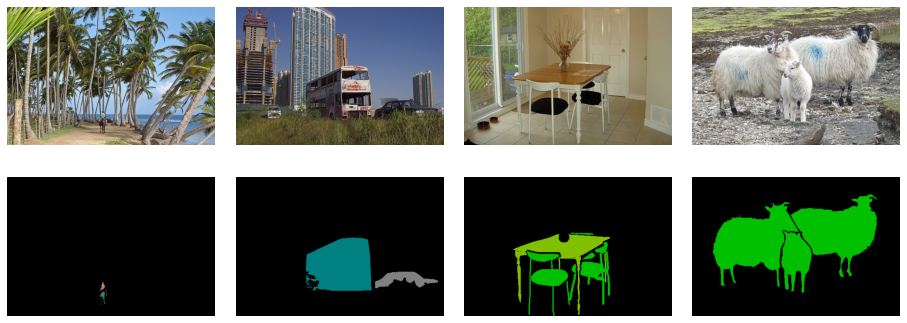

In [21]:
## 可视化一个batch的图像，检查数据预处理 是否正确
b_x_numpy = b_x.data.numpy()
b_x_numpy = b_x_numpy.transpose(0,2,3,1)
b_y_numpy = b_y.data.numpy()
plt.figure(figsize=(16,6))
for ii in range(4):
    plt.subplot(2,4,ii+1)
    plt.imshow(inv_normalize_image(b_x_numpy[ii]))
    plt.axis("off")
    plt.subplot(2,4,ii+5)
    plt.imshow(label2image(b_y_numpy[ii],colormap))
    plt.axis("off")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


## 网络搭建

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class Unet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(Unet, self).__init__()

        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64, out_ch, 1)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1) # 延此维度连接张量序列
        c6=self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)
        out = nn.Sigmoid()(c10)
        return c10

In [10]:
unet = Unet(3,21).to(device)
summary(unet.to(device),input_size=(3, 320,480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 480]           1,792
       BatchNorm2d-2         [-1, 64, 320, 480]             128
              ReLU-3         [-1, 64, 320, 480]               0
            Conv2d-4         [-1, 64, 320, 480]          36,928
       BatchNorm2d-5         [-1, 64, 320, 480]             128
              ReLU-6         [-1, 64, 320, 480]               0
        DoubleConv-7         [-1, 64, 320, 480]               0
         MaxPool2d-8         [-1, 64, 160, 240]               0
            Conv2d-9        [-1, 128, 160, 240]          73,856
      BatchNorm2d-10        [-1, 128, 160, 240]             256
             ReLU-11        [-1, 128, 160, 240]               0
           Conv2d-12        [-1, 128, 160, 240]         147,584
      BatchNorm2d-13        [-1, 128, 160, 240]             256
             ReLU-14        [-1, 128, 1

## 网络训练和测试

In [28]:
## 网络的训练函数
def train_model(model, criterion, optimizer,traindataloader,
                valdataloader, num_epochs=25):
    """
    model:网络模型；criterion：损失函数；optimizer：优化方法；
    traindataloader:训练数据集，valdataloader:验证数据集
    num_epochs:训练的轮数
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        train_loss = 0.0
        train_num = 0
        val_loss = 0.0
        val_num = 0
        # 每个epoch包括训练和验证阶段
        model.train() ## 设置模型为训练模式
        for step,(b_x,b_y) in enumerate(traindataloader):
            optimizer.zero_grad() 
            b_x  =b_x.float().to(device)
            b_y  =b_y.long().to(device)
            out = model(b_x)
            out = F.log_softmax(out,dim=1)
            pre_lab = torch.argmax(out,1) # 预测的标签
            loss = criterion(out, b_y) # 计算损失函数值       
            loss.backward()       
            optimizer.step()  
            train_loss += loss.item() * len(b_y)
            train_num += len(b_y)
        ## 计算一个epoch在训练集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        print('{} Train Loss: {:.4f}'.format(epoch, train_loss_all[-1]))
        
        ## 计算一个epoch的训练后在验证集上的损失
        model.eval() ## 设置模型为训练模式评估模式 
        for step,(b_x,b_y)  in enumerate(valdataloader):
            b_x  =b_x.float().to(device)
            b_y  =b_y.long().to(device)
            out = model(b_x)
            out = F.log_softmax(out,dim=1)
            pre_lab = torch.argmax(out,1)
            loss = criterion(out, b_y)   
            val_loss += loss.item() * len(b_y)
            val_num += len(b_y)
        ## 计算一个epoch在训练集上的损失和精度
        val_loss_all.append(val_loss / val_num)
        print('{} Val Loss: {:.4f}'.format(epoch, val_loss_all[-1]))
        ## 保存最好的网络参数
        if val_loss_all[-1] < best_loss:
                best_loss = val_loss_all[-1]
                best_model_wts = copy.deepcopy(model.state_dict())
        ## 没个epoch的花费时间
        time_use = time.time() - since
        print("Train and val complete in {:.0f}m {:.0f}s".format(
            time_use // 60, time_use % 60))
    train_process = pd.DataFrame(
        data={"epoch":range(num_epochs),
              "train_loss_all":train_loss_all,
              "val_loss_all":val_loss_all})  
    ## 输出最好的模型
    model.load_state_dict(best_model_wts)
    return model,train_process

In [30]:
## 定义损失函数和优化器
LR = 0.0003
criterion = nn.NLLLoss()
optimizer = optim.Adam(unet.parameters(), lr=LR,weight_decay=1e-4)
## 对模型进行迭代训练,对所有的数据训练EPOCH轮
unet,train_process = train_model(
    unet,criterion, optimizer,train_loader,
    val_loader,num_epochs=25)
## 保存训练好的网络unet
torch.save(unet,"unet.pkl")

Epoch 0/24
----------
0 Train Loss: 2.0371
0 Val Loss: 1.9431
Train and val complete in 0m 23s
Epoch 1/24
----------
1 Train Loss: 1.5565
1 Val Loss: 1.5104
Train and val complete in 0m 45s
Epoch 2/24
----------
2 Train Loss: 1.2979
2 Val Loss: 1.2816
Train and val complete in 1m 7s
Epoch 3/24
----------
3 Train Loss: 1.1872
3 Val Loss: 1.2089
Train and val complete in 1m 30s
Epoch 4/24
----------
4 Train Loss: 1.1578
4 Val Loss: 1.1781
Train and val complete in 1m 52s
Epoch 5/24
----------
5 Train Loss: 1.1146
5 Val Loss: 1.1795
Train and val complete in 2m 15s
Epoch 6/24
----------
6 Train Loss: 1.1029
6 Val Loss: 1.1581
Train and val complete in 2m 37s
Epoch 7/24
----------
7 Train Loss: 1.0939
7 Val Loss: 1.1996
Train and val complete in 3m 0s
Epoch 8/24
----------
8 Train Loss: 1.0939
8 Val Loss: 1.1464
Train and val complete in 3m 23s
Epoch 9/24
----------
9 Train Loss: 1.1045
9 Val Loss: 1.1379
Train and val complete in 3m 45s
Epoch 10/24
----------
10 Train Loss: 1.0973
10 Val 

PicklingError: Can't pickle <class '__main__.Unet'>: it's not the same object as __main__.Unet

In [31]:
train_process

,epoch,train_loss_all,val_loss_all
0,0,2.037141,1.943144
1,1,1.556529,1.510433
2,2,1.297937,1.281591
3,3,1.187171,1.208928
4,4,1.157818,1.178148
5,5,1.114582,1.179540
6,6,1.102869,1.158120
7,7,1.093929,1.199636
8,8,1.093873,1.146410
9,9,1.104501,1.137922


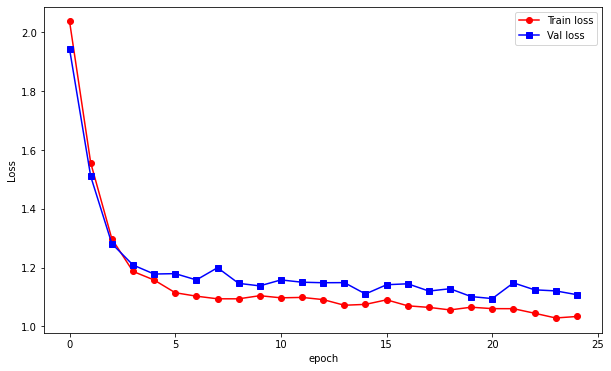

In [32]:
## 可视化模型训练过程中
plt.figure(figsize=(10,6))
plt.plot(train_process.epoch,train_process.train_loss_all,
         "ro-",label = "Train loss")
plt.plot(train_process.epoch,train_process.val_loss_all,
         "bs-",label = "Val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

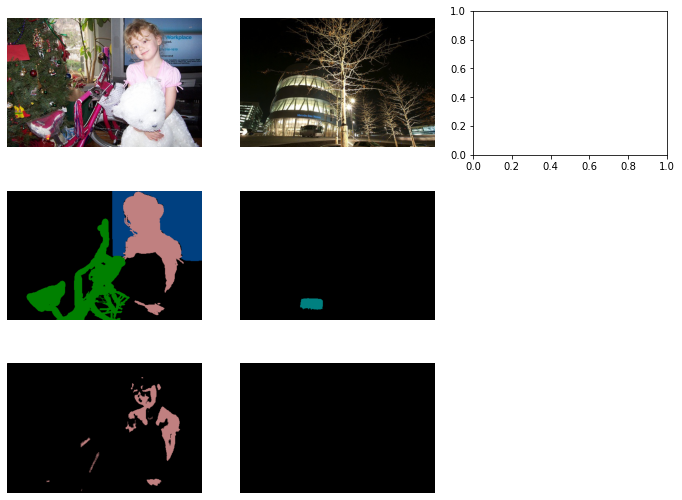

In [33]:
##  从验证集中获取一个batch的数据
for step, (b_x, b_y) in enumerate(val_loader):  
    if step > 0:
        break
## 对验证集中一个batch的数据进行预测，并可视化预测效果
unet.eval()
b_x  =b_x.float().to(device)
b_y  =b_y.long().to(device)
out = unet(b_x)
out = F.log_softmax(out,dim=1)
pre_lab = torch.argmax(out,1)
## 可视化一个batch的图像，检查数据预处理 是否正确
b_x_numpy = b_x.cpu().data.numpy()
b_x_numpy = b_x_numpy.transpose(0,2,3,1)
b_y_numpy = b_y.cpu().data.numpy()
pre_lab_numpy = pre_lab.cpu().data.numpy()
plt.figure(figsize=(16,9))
for ii in range(4):
    plt.subplot(3,4,ii+1)
    plt.imshow(inv_normalize_image(b_x_numpy[ii]))
    plt.axis("off")
    plt.subplot(3,4,ii+5)
    plt.imshow(label2image(b_y_numpy[ii],colormap))
    plt.axis("off")
    plt.subplot(3,4,ii+9)
    plt.imshow(label2image(pre_lab_numpy[ii],colormap))
    plt.axis("off")
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()
